In [1]:
import pandas as pd
import numpy as np
import timeit, math, os, copy, yaml, ast
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.optimize import curve_fit

from drawing_utilities import *
import numpy as np
import copy
import os
from rebinning import *
from scipy import ndimage
#%load_ext memory_profiler

In [2]:
me = "hRHGlobalm2"
[my_dir for my_dir in os.listdir(".") if me in my_dir]

['hRHGlobalm2_180924_s0.parquet',
 'hRHGlobalm2_180924_s1.npz',
 'hRHGlobalm2_180924norebin_s1.npz',
 'hRHGlobalm2_240724_s0.parquet',
 'hRHGlobalm2_240724_s00.parquet',
 'hRHGlobalm2_240724_s01.parquet',
 'hRHGlobalm2_240724_s02.parquet',
 'hRHGlobalm2_240724_s1.npz',
 'hRHGlobalm2_240724rebinned_s1.npz',
 'hRHGlobalm2model_180924.pth']

In [3]:
my_dir = "/eos/cms/store/group/ml/AD4MVDHackathon/ML4DQM_MUON/anomalies/"
file = "hRHGlobalm2_280824_s1.npz"
data = np.load(my_dir+file)

In [4]:
#data.files has "bad_flag": 1 for good data, -1 for bad data

data_np = np.array(data["bad_flag"])

good_data_filter = data_np == 1

imgs = data["no_rebin_imgs"][good_data_filter]

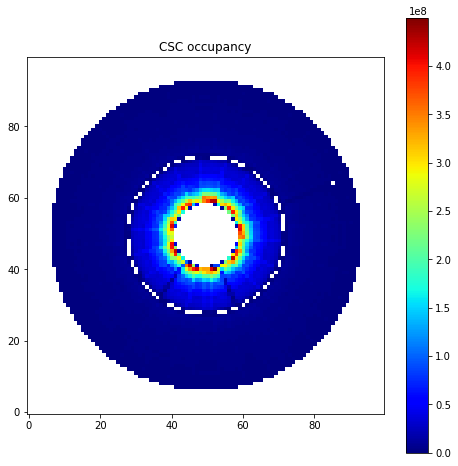

In [5]:
sum_img = np.sum(imgs,axis=0)
Show2Dimg(sum_img)

In [6]:
inner_radius,outer_radius = station3_boundaries()
regions = make_rebin_regions(sum_img,inner_radius,50,4,1)

### Class for making bad slices (excess or hole)

In [7]:
class createSlices:
        
    def __init__(self,mean_matrix, inner_radius, outer_radius, divisions, sigma=0.2):
        self.sigma = sigma
        self.mean_matrix = mean_matrix
        self.inner_radius = inner_radius
        self.outer_radius = outer_radius
        self.mask = self._make_mask(inner_radius,outer_radius)
        
        #remap regions to have values in range ]0,num_regions]
        regions = make_rebin_regions(mean_matrix,inner_radius-3.,outer_radius+3.,divisions,1)
        region_values = np.unique(regions)
        region_values = np.delete(region_values, np.where(region_values==0))

        mapping = {num: idx + 1 for idx, num in enumerate(region_values)}
        mapping[0] = 0
        for i in range(len(regions)):
            for j in range(len(regions[i])):
                regions[i][j] = mapping[regions[i][j]]

        self.regions = regions.astype(float)
        
    
    def _make_mask(self,inner_radius,outer_radius):
        empty_img = np.zeros_like(self.mean_matrix, dtype=np.int16)
        hole = make_disk(empty_img, self.inner_radius, 1)
        hole = np.abs(hole - 1)
        hole *= make_disk(empty_img, self.outer_radius+3., 1)
        return hole
    
    def _get_slice(self,indices):
        
        my_slice = np.where(np.isin(self.regions, indices), 1.0, 0.0)

        blurred_slice = ndimage.gaussian_filter(my_slice, sigma=self.sigma)
        
        return blurred_slice*self.mask
    
    def get_hole(self,indices):
        return 1 - self._get_slice(indices)
    
    def get_excess(self,indices, factor):
        my_slice = self._get_slice(indices)
        return np.where(my_slice != 0, factor, 1.0)
        
        
slice_maker = createSlices(sum_img,inner_radius,outer_radius,4)

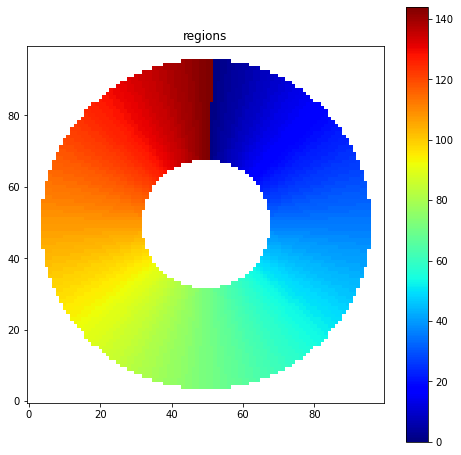

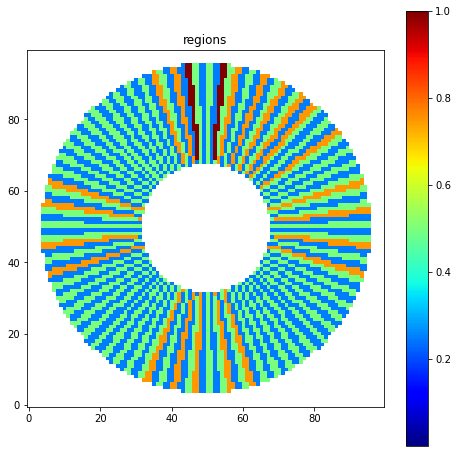

In [8]:
Show2Dimg((slice_maker.regions.astype(float)), title="regions")
Show2Dimg(assign_colors(slice_maker.regions.astype(float)), title="regions")

In [9]:
print(f"There are {len(np.unique(slice_maker.regions))} regions, (including 0)")

There are 145 regions, (including 0)


### Basic example of excess/hole

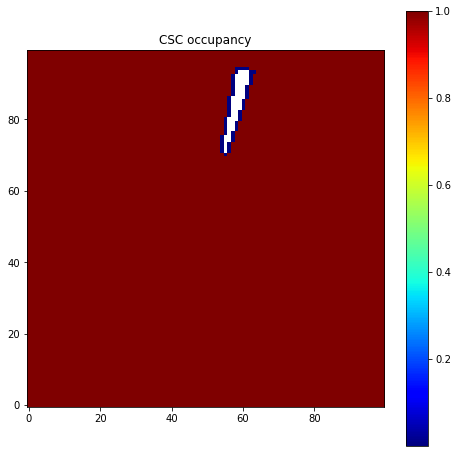

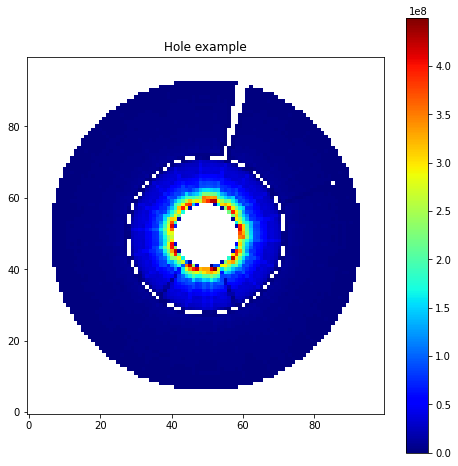

In [10]:
hole = slice_maker.get_hole([4,5,6])
Show2Dimg(hole)
Show2Dimg(sum_img*hole, title="Hole example")

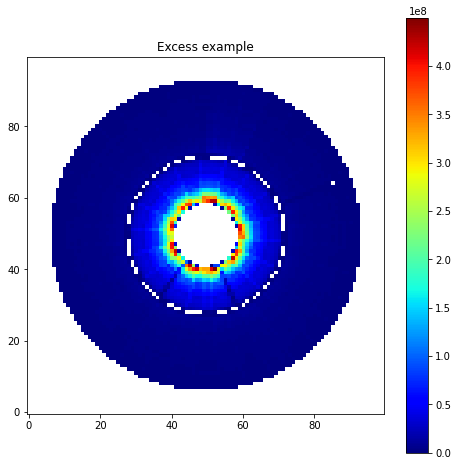

In [11]:
excess = slice_maker.get_excess([1,2,3,4,5,6,7,8],2)
Show2Dimg(sum_img*excess, title="Excess example")

In [12]:
import numpy as np

array = np.unique(slice_maker.regions)
array = np.delete(array,0)
group_size = 4

reshaped_arrays = [0,1,2,3]

# Reshape into groups of 1
reshaped_arrays[0] = array.reshape(-1, 1)
# Reshape into groups of 2
reshaped_arrays[1] = array.reshape(-1, 2)


# Reshape into groups of 3
reshaped_arrays[2] = array.reshape(-1, 4)
reshaped_arrays[2] = reshaped_arrays[2][:, :3]

# Reshape into groups of 4
reshaped_arrays[3] = array.reshape(-1, 4)


slice_indices_list = reshaped_arrays
[len(slice_indices) for slice_indices in slice_indices_list]

[144, 72, 36, 36]

In [13]:
def make_hole(slice_maker, image, slice_index):
    image_copy = copy.deepcopy(image)
    hole = slice_maker.get_hole(slice_index)
    image_copy *= hole
    return image_copy

def make_excess(slice_maker, image, slice_index, factor):
    image_copy = copy.deepcopy(image)
    excess = slice_maker.get_excess(slice_index, factor)
    image_copy *= excess
    return image_copy

In [14]:
images_holes = []
images_excess_2 = []
images_excess_3 = []
image_index = 0

#First make some holes
for slice_indices in slice_indices_list[::-1]:
    for slice_index in slice_indices:
        my_image = imgs[image_index]
        image_index += 1
        holed_image = make_hole(slice_maker,my_image,slice_index)
        images_holes.append(holed_image)
    
#Then make some excesses, factor of 2
for slice_indices in slice_indices_list[::-1]:
    for slice_index in slice_indices:
        my_image = imgs[image_index]
        image_index += 1
        excessed_image = make_excess(slice_maker,my_image,slice_index, factor=2.5)
        images_excess_2.append(excessed_image)
        
        

#Then make some excesses, factor of 3
for slice_indices in slice_indices_list[::-1]:
    for slice_index in slice_indices:
        my_image = imgs[image_index]
        image_index += 1
        excessed_image = make_excess(slice_maker,my_image,slice_index, factor=3.5)
        images_excess_3.append(excessed_image)

bad_images = images_holes + images_excess_2 + images_excess_3
bad_images = np.array(bad_images)
image_index

864

HOLES


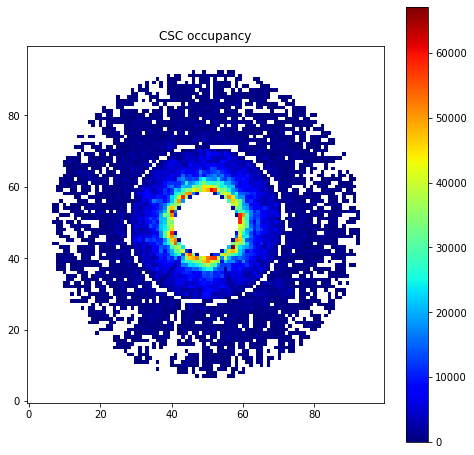

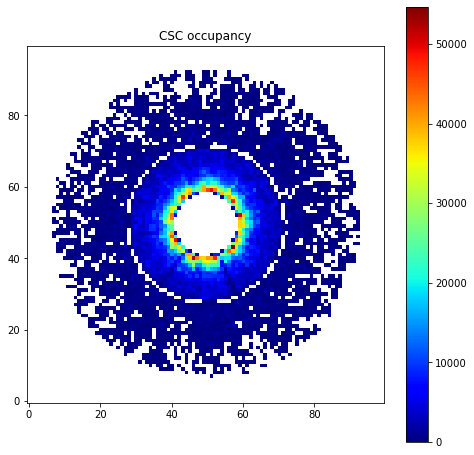

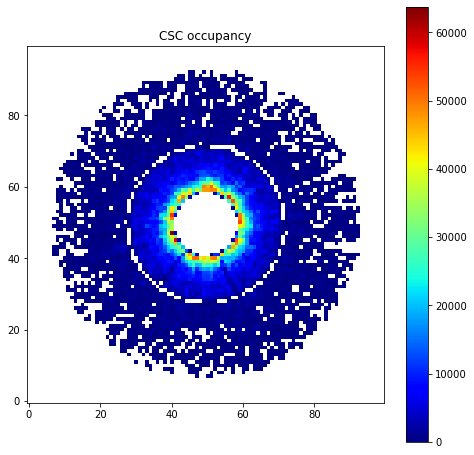

EXCESSES


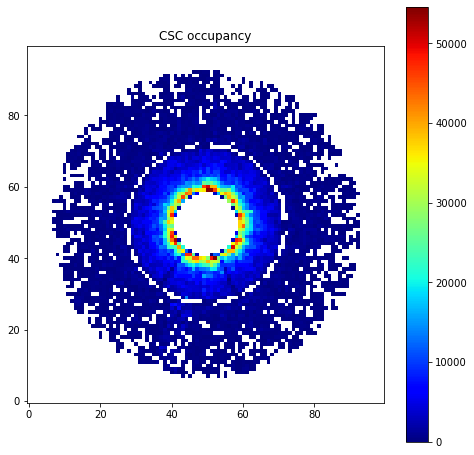

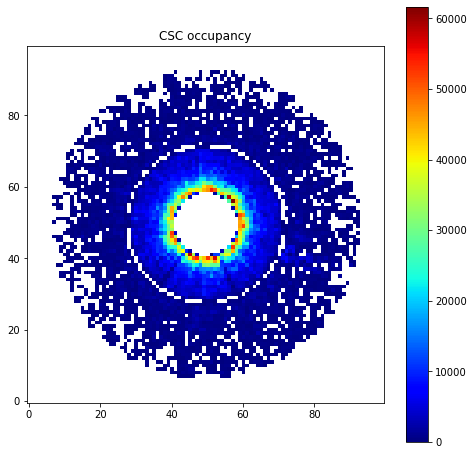

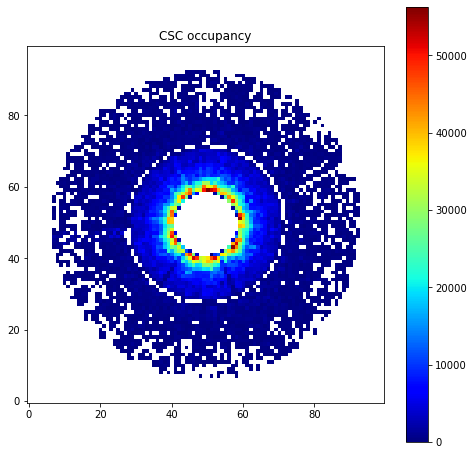

In [15]:
indices = [len(slice_indices) for slice_indices in slice_indices_list][::-1]
random_values = []

for i in range(len(indices)-1):
    low = sum(indices[:i+1])
    high = sum(indices[:i+2])
    random_value = np.random.randint(low, high)
    random_values.append(random_value)

#show a few images with holes
print("HOLES")
for i in random_values:
    Show2Dimg(images_holes[i])
#show a few images with excess
print("EXCESSES")
for i in random_values:
    Show2Dimg(images_excess_3[i])

### Now save this to a new file

In [17]:
# Slice all arrays to the desired length
sliced_data = {key: data[key][:image_index] for key in data.files}
sliced_data.pop('imgs')
sliced_data['no_rebin_imgs'] = bad_images

In [18]:
# Save the sliced arrays to a new npz file
my_dir = "/eos/cms/store/group/ml/AD4MVDHackathon/ML4DQM_MUON/anomalies/"
new_file = "hRHGlobalm2_180924_outer_anomalies.npz"

# Save the sliced arrays to a new npz file
np.savez(my_dir+new_file, **sliced_data)

In [19]:
#open the new_file again and to double check if it is correct
data = np.load(my_dir+new_file)

imgs = data['no_rebin_imgs']

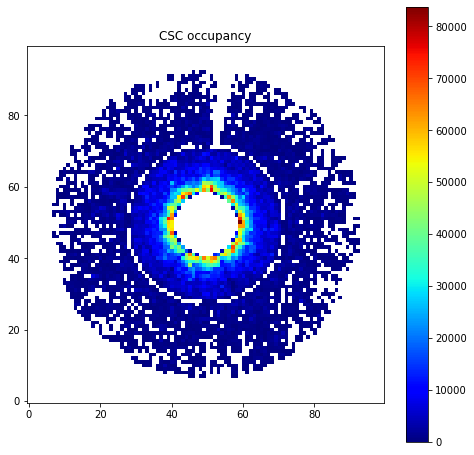

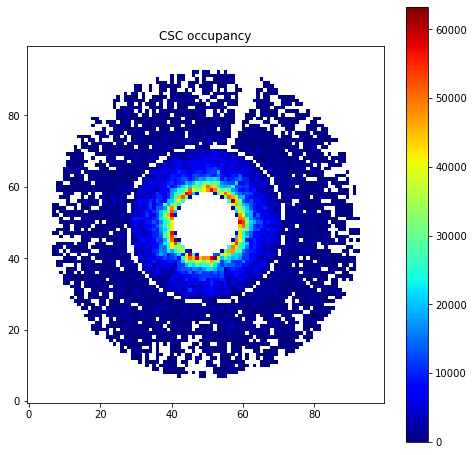

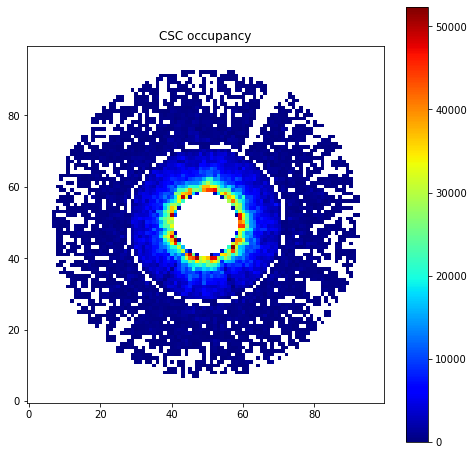

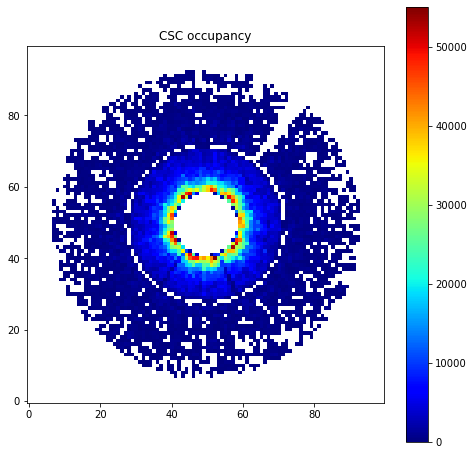

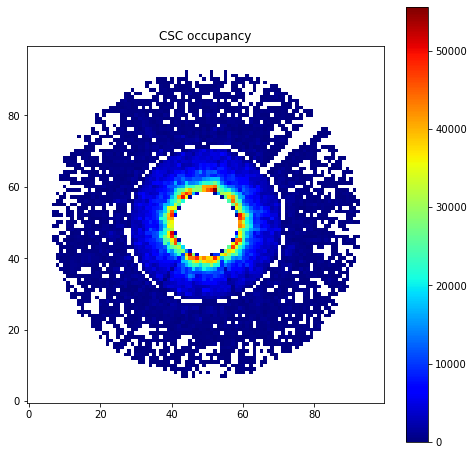

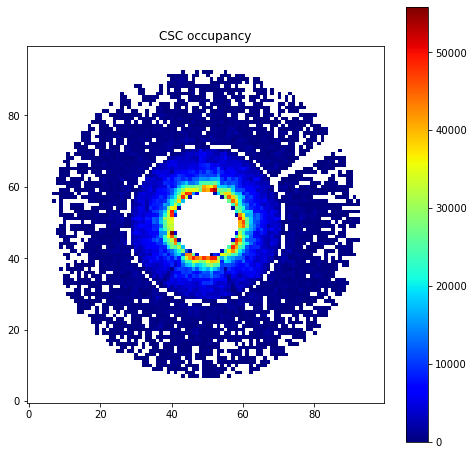

In [20]:
for index,img in enumerate(imgs):
    Show2Dimg(img)
    if index == 5:
        break